# Gravitational settling



## eEMEP

non-spherical, F=0.8=(d1+d2)/(2*d3)

In [4]:
import numpy as np

def potential_temperature(tempC, presPa):
    return (tempC+273.15)*(100000/presPa)**0.286

def monodisperse_terminal_v(diameter,
                            density_p, # kg/m3
                            pot_temp,
                            pressure_mid):

    """
    Calculate monodisperese terminal fall velocity volcanic ash using equations
    as used in Steensen (2017) paper from Zannetti (1990) + cunnigham slip factor + drag
    coefficient for near spherical particles (F=0.8)
    https://gmd.copernicus.org/articles/10/1927/2017/gmd-10-1927-2017.pdf section 2.2.4

    inputs: diameter in [m]
            density_p [kg/m3]
            pot_temp in [K];   array of mid-point pot. temperatures
            pressure_mid [Pa]; array of mid-point pressure levels

    """

    r_specific = 287.050
    kappa = 0.286
    F = 0.8
    g = 9.81

    temp_abs = pot_temp * np.exp(kappa*np.log(pressure_mid*1e-5))
    density_a = pressure_mid / r_specific / temp_abs

    temperature = temp_abs - 273.15 # here in celsius
    zvis = np.empty(np.shape(temperature))

    for index, item in enumerate(temperature): # temperature here in deg. Celsius
        if item >= 0:
            zvis[index] = (1.718 + 0.0049*item)*1e-5 # [Pa s]
        else:
            zvis[index] = (1.718 + 0.0049*item - 1.2e-05*(item**2))*1e-5 # [Pa s]

    # temperature here in Kelvin
    zair = 6.6e-8 * (1013.25 / (pressure_mid * 1e-2)) * (temp_abs / 293.15) # [m]

    quad_a = 6 * density_a * np.sqrt(1.07 - F)
    quad_b = 72 * zvis / diameter * F ** -0.828
    quad_c = -4 * g * (density_p - density_a) * diameter

    zdum = (-quad_b + np.sqrt(quad_b**2 - 4 * quad_a * quad_c)) / (2 * quad_a)

    knut = 2 * zair / diameter
    v_t = zdum * (1 + 1.257 * knut + 0.4 * np.exp(-1.1 / knut)) # m/s

    return v_t


[Text(0.5, 0, 'fall velocity [km/h]'), Text(0, 0.5, 'height [m]')]

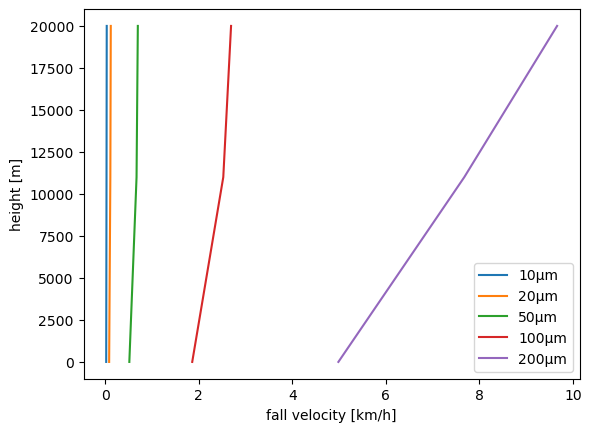

In [5]:
from matplotlib import pyplot as plt

std_atmosphere = {
    "height": np.array([0., 11000., 20000.]),
    "pressure": np.array([101325., 22632., 5475.]),
    "temperature": np.array([15., -56.5, -56.5]),
}
pot_temp = potential_temperature(presPa=std_atmosphere["pressure"], tempC=std_atmosphere["temperature"])

fig, ax = plt.subplots()
for psize in [10, 20, 50, 100, 200]:
    fall_velocities = monodisperse_terminal_v(psize*1e-6,
                                            2300,
                                            pot_temp,
                                            std_atmosphere["pressure"])
    ax.plot(fall_velocities*3.6, std_atmosphere["height"],label=f"{psize}µm")
ax.legend()
ax.set(xlabel='fall velocity [km/h]', ylabel="height [m]")


## SNAP vgrav

Zannetti (1990) and RAF (1999)

In [ ]:

def cun(dp):
    """cunningham factor (Zannetti (1990))
    c = 1 + (2*l/dp)*(a1+a2*exp(-a3*dp/l))

    :param dp: particle size in µm
    """
    a1=1.257
    a2=0.40
    a3=0.55
    l=0.0653
    cun=1.0+(2.0*l/dp)*(a1+a2*np.exp(-a3*dp/l))
    return cun

def vgrav(dp, rp, pressure, temperature):
    """snap vgrav function

    :param dp: particle size [µm]
    :param rp: density [g/cm3]
    :param pressure: [hPa]
    :param temperature: absolute temp [K]
    """
    # air density, RAF (1999)
    rho_air = 0.001*pressure*100/(287.4 * temperature)
    # viscosity according to RAFF (1999), Kyle (1991) in poise = g/(cm*s)
    visc = 1.72e-4*(393.0/(temperature+120.0))*(temperature/273.0)**1.5
    g = 981 # cm/s

    vgrav=(dp*0.0001)**2 * g*(rp-rho_air)*cun(dp) / (18.0*visc)
    return vgrav


def grav_snap(diameter, density_p, temperature, pressure):
    """
    inputs: diameter in [m]
            density_p [kg/m3]
            temperature in [C]; temperatures
            pressure_mid [Pa]; pressure
    outputs: speed in [m/s]
    """
    return vgrav(diameter*1e6, density_p/1000, pressure/100, temperature+273.15)*0.01

def gravitational_settling(roa, diam, ro_part):
    """new code implemented for new dry-depositions (surface)

    :param roa: air densitiy [kg/m3]
    :param diam: diameter in [m]
    :param ro_part: particle density [kg/m3]
    :return: velocity in [m/s]
    """
    # mean free path in air [m]
    lam = 0.065e-6
    # gravity [m/s]
    grav = 9.8
    # Kinematic viscosity of air, m2 s-1 at +15 C
    ny = 1.5e-5

    my = ny * roa
    fac1 = -0.55 * diam / lam
    cslip = 1 + 2 * lam / diam * ( 1.257 + 0.4 * np.exp(fac1) )

    vs = ro_part * diam * diam * grav * cslip / (18*my)
    return vs

[Text(0.5, 0, 'fall velocity [km/h]'), Text(0, 0.5, 'height [m]')]

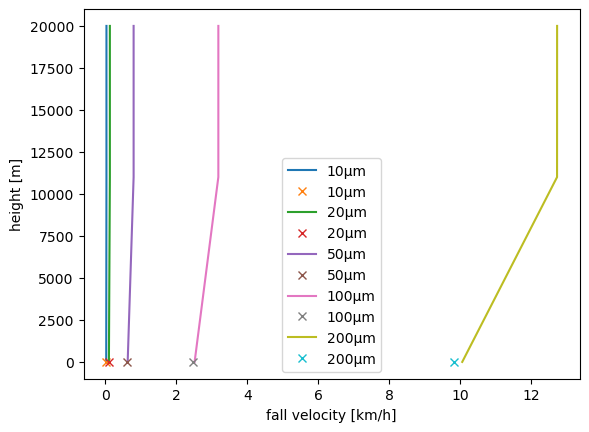

In [7]:

fig, ax = plt.subplots()
for psize in [10, 20, 50, 100, 200]:
    fall_velocities = grav_snap(psize*1e-6,
                                2300,
                                std_atmosphere["temperature"],
                                std_atmosphere["pressure"])
    ax.plot(fall_velocities*3.6, std_atmosphere["height"],label=f"{psize}µm")
    rho_air = 101325/(287.4 * (15+273.15))
    ax.plot(gravitational_settling(rho_air, psize*1e-6, 2300)*3.6, 0, 'x', label=f"{psize}µm")
ax.legend()
ax.set(xlabel='fall velocity [km/h]', ylabel="height [m]")



## Dynamic viscosity

### eEMEP
after https://pub.deadnet.se/Books_and_manuals_on_various_stuff/Geology/Microphysics%20of%20Clouds%20and%20Precipitation%202nd%20ed%20-%20H.%20Pruppacher%2C%20J.%20Klett%20%28Kluwer%2C%201997%29%20WW.pdf eq. 10-141a/b

In [ ]:
def visc_eemep(t):
    """dynamic viscosity in poise after Pruppacher-Klett
    Microphysics of Clounds and Precipitaiton, eq. 10-141a/b

    :param t: temperature [°C]
    :return: viscosity in [Pa s = 10 poise]
    """

    if t >= 0:
        vis = (1.718 + 0.0049*t)*1e-5 # [Pa s]
    else:
        vis = (1.718 + 0.0049*t - 1.2e-05*(t**2))*1e-5 # [Pa s]

    return vis


### SNAP



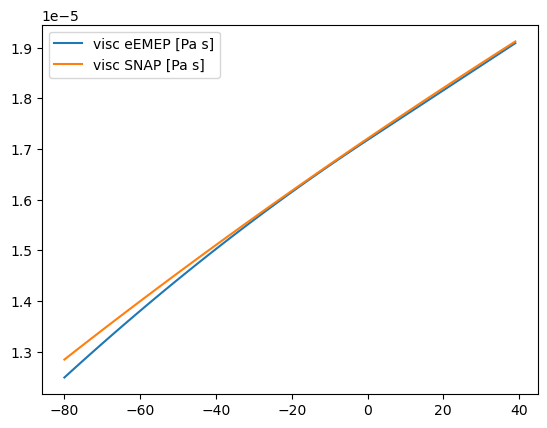

In [23]:
def visc_snap(t):
    t_K = t+273.15
    visc = 1.72e-4*(393.0/(t_K+120.0))*(t_K/273.0)**1.5 # poise
    return visc/10 # Pa s

temps = np.arange(-80,40,1)
ny_eemep = [visc_eemep(t) for t in temps]
plt.plot(temps, ny_eemep, label="visc eEMEP [Pa s]")
temps = np.arange(-80,40,1)
ny = [visc_snap(t) for t in temps]
plt.plot(temps, ny, label="visc SNAP [Pa s]")
plt.legend()
